In [34]:
import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
import datetime
from scipy.signal import find_peaks
from decimal import Decimal
import heartpy as hp

In [13]:
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_All_Data'

In [14]:
data, _ = hp.load_exampledata(0)
data

array([530., 518., 506., ..., 492., 493., 494.])

Helper function that returns a list of floats iterated upwards by sample rate


In [15]:
def iterate_sample_rate(df_length, fs):
    # returns list of floats starting from zero iterated upward by sample rate
    result = []
    curr_time = 0.0
    result.append(curr_time)
    
    for i in range(df_length-1):
        curr_time += 1.0/fs
        result.append(curr_time)
    return result

In [16]:
file_path = r'/Users/dancohen/Dropbox/E4 stuff/test data'
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/IBI_All_Data'
all_folders = glob.glob(file_path + "/PRF*")

Helper function that finds the number of seconds differenc between (t_0, a unix timestamp) and a datetime

In [17]:
def t_0_diff_seconds(t_0, date_time):
    return (date_time - pd.to_datetime(t_0, unit='s', infer_datetime_format = True)).total_seconds()

Helper function that takes a dataframe with a column in seconds and normalizes the values in that column to start at 0.00 seconds

In [18]:
def normalize_df(start_df, col_label):
    #Make a copy here to prevent chaining assignment in the dataframe
    start_seconds = start_df.iloc[0][0]
    cp = start_df.copy()
    cp[col_label] = start_df.apply(lambda x: x[col_label]-start_seconds, axis=1)
    cp = cp.reset_index(drop=True)
    #cp = cp.set_index(col_label)
    return cp

Helper function to calculate summary stats for IBI

In [32]:
def ibi_sum_stats(data_col, part_id):
    nn_50 = np.sum(np.abs(np.diff(data_col)) > 0.05)*1
    rmssd = np.sqrt(np.mean(np.square(np.diff(data_col))))
    sdnn = np.std(data_col)
    pnn_50 = 100 * nn_50 / len(data_col)
    stats = {part_id: [nn_50, rmssd, sdnn, pnn_50]}
    names = ['NN50', 'RMSSD', 'SDNN', 'pNN50']
    df = pd.DataFrame(stats)
    df['stats'] = names
    df = df.set_index('stats')
    return df

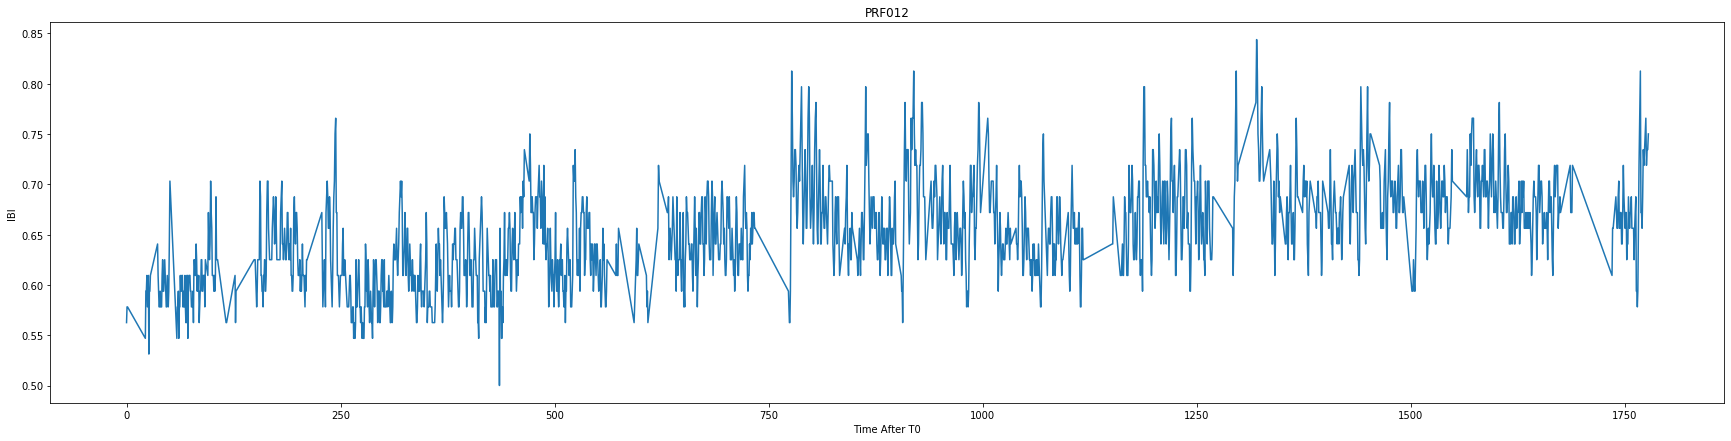

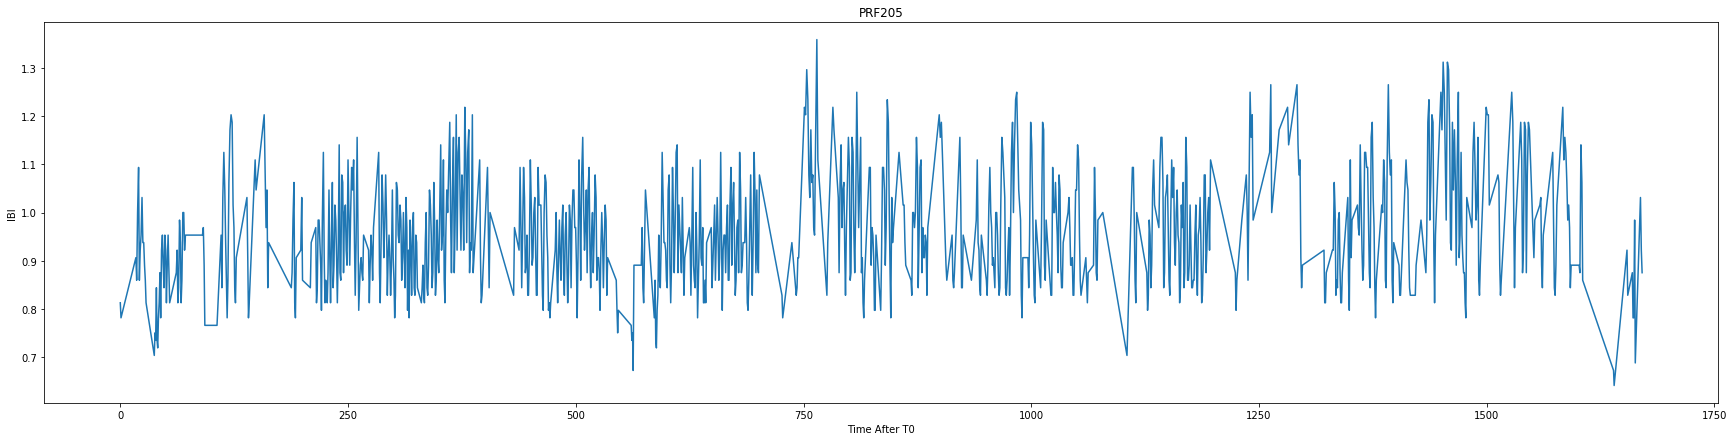

Error occurred parsing tags.csv for PRF020.  Error: 6. This file will be skipped.


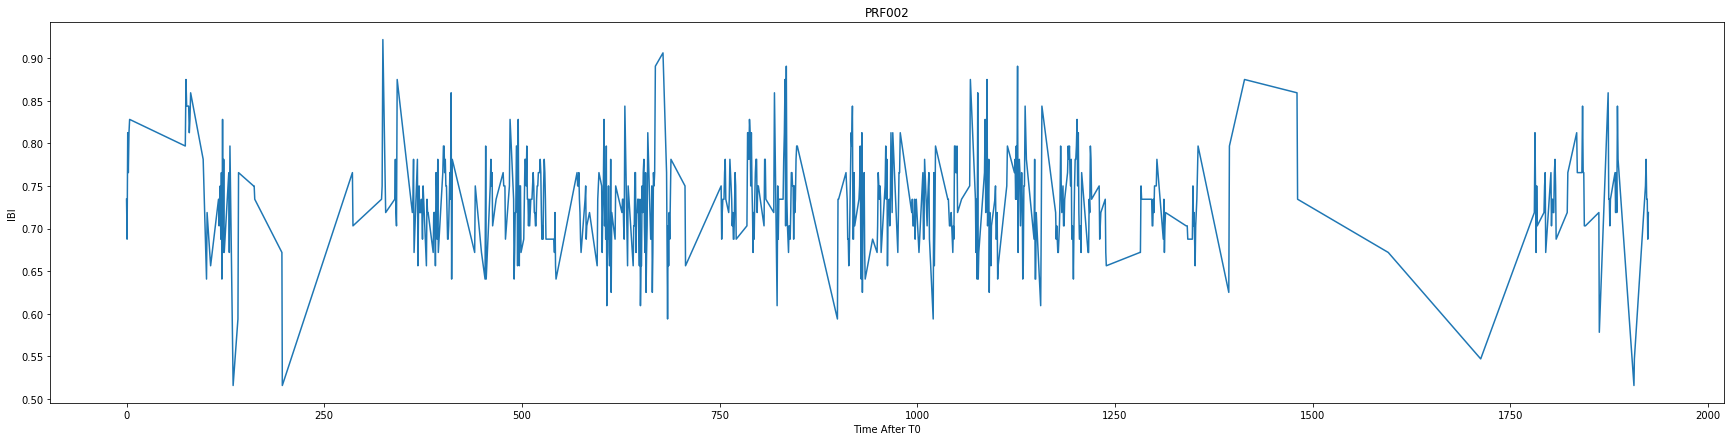

In [92]:
ibi_list = []
st_1_2 = []
ibi_1_2 = []
st_2_3 = []
ibi_2_3 = []
st_3_end = []
ibi_3_end = []

for folder in all_folders:
    spl = folder.split('/')
    
    #Folder names are 'PRF###' (participant ID) and we are interested in the ID
    part_id = spl[len(spl)-1][3:]
    
    # Grab the csv containing the timestamps that mark the start and end times of the scripts
    script_times = pd.read_csv(folder+"/tags.csv", header=None)
    script_times = script_times.apply(lambda x: pd.to_datetime(x, unit='s'))

        
    ibi_df_raw = pd.read_csv(folder+"/IBI.csv")
    starting_timestamp = ibi_df_raw.columns[0]
    
    try:
        begin_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[1].iat[0])
        end_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[2].iat[0])
        
        begin_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[3].iat[0])    
        end_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[4].iat[0])

        begin_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[5].iat[0])
        end_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[6].iat[0])
    except Exception as err:
        print("Error occurred parsing tags.csv for PRF{}.  Error: {}. This file will be skipped.".format(part_id, err))
        continue
    
    start_seconds = ibi_df_raw.loc[0].iat[0]
    #Normalize T0 down to 0 for the rest of the column.  This will make plotting data against each other easier later
    normalized_time = ibi_df_raw[starting_timestamp].apply(lambda x: x-start_seconds)

    ibi_df_raw[starting_timestamp] = normalized_time
    
    ibi_df = ibi_df_raw.rename(columns={starting_timestamp: "Time_After_T0", " IBI":part_id})
    
    df_1_2 = ibi_df[(ibi_df['Time_After_T0'] >= end_s1) & (ibi_df['Time_After_T0'] < begin_s2)]
    df_2_3 = ibi_df[(ibi_df['Time_After_T0'] >= end_s2) & (ibi_df['Time_After_T0'] < begin_s3)]
    df_3_end = ibi_df[(ibi_df['Time_After_T0'] >= end_s3)]
    
    #Normalize each frame's timestamp down to 0.00 seconds once we know where the timing cutoffs for each frame are
    #See lines above
    norm_1_2 = df_1_2.iloc[0][1]
    cp_1_2 = normalize_df(df_1_2, 'Time_After_T0')
    stat_1_2 = ibi_sum_stats(cp_1_2[part_id], part_id)
    cp_1_2 = cp_1_2.transpose()
    st_1_2.append(stat_1_2)
    
    norm_2_3 = df_2_3.iloc[0][1]
    cp_2_3 = normalize_df(df_2_3, 'Time_After_T0')
    stat_2_3 = ibi_sum_stats(cp_2_3[part_id], part_id)
    st_2_3.append(stat_2_3)
    cp_2_3 = cp_2_3.transpose()
    
    norm_3_end = df_3_end.iloc[0][1]
    cp_3_end  = normalize_df(df_3_end, 'Time_After_T0')
    stat_3_end = ibi_sum_stats(cp_3_end[part_id], part_id)
    st_3_end.append(stat_3_end)
    cp_3_end = cp_3_end.transpose()
    
    ibi_1_2.append(cp_1_2)
    ibi_2_3.append(cp_2_3)
    ibi_3_end.append(cp_3_end)
    ibi_list.append(ibi_df.transpose())
    
    plt.figure(figsize=(30, 7))

    plt.plot(ibi_df['Time_After_T0'], ibi_df[part_id] )
    plt.title("PRF{}".format(part_id))
    plt.ylabel('IBI')
    plt.xlabel('Time After T0')
    plt.savefig(output_path+"/IBI{}.pdf".format(part_id))
    plt.show()

In [23]:
df_1_2 = pd.concat(ibi_1_2)
stats_1_2 = pd.concat(st_1_2, axis=1)
df_2_3 = pd.concat(ibi_2_3)
stats_2_3 = pd.concat(st_2_3, axis=1)
df_3_end = pd.concat(ibi_3_end)
stats_3_end = pd.concat(st_3_end, axis=1)

In [24]:
df_1_2.to_csv(output_path+"/IBI_1_2.csv", float_format='%.6f')
df_2_3.to_csv(output_path+"/IBI_2_3.csv", float_format='%.6f')
df_3_end.to_csv(output_path+"/IBI_3_end.csv", float_format='%.6f')

In [25]:
stats_1_2.to_csv(output_path+"/stats_1_2.csv", float_format='%.6f')
stats_2_3.to_csv(output_path+"/stats_2_3.csv", float_format='%.6f')
stats_3_end.to_csv(output_path+"/stats_3_end.csv", float_format='%.6f')

In [272]:
df = pd.concat(ibi_list)
df = df.transpose()

In [273]:
df.to_csv(output_path+"/IBI_All_Participants.csv", float_format='%.6f')